In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.utils import resample

In [12]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [13]:
# loading data
file = path_data / Path("dataset.csv")
with Path.open(file, 'rb') as fp:
    df = pd.read_csv(fp,  encoding='utf-8',low_memory=False, index_col = 0)

In [14]:
# load feature sets
filename = path_dump / Path("dict_features_sets.sav")
with open(filename, 'rb') as fp:
     dict_features_sets = pickle.load(fp)

usual_common_features = dict_features_sets['usual_common_features']
indiv_act_features = dict_features_sets['indiv_act_features']
lasso_20_features = dict_features_sets['lasso_20_features']

In [15]:
scope = lasso_20_features | indiv_act_features

In [19]:
n_max = 2000

df_tmp = df.loc[:,lasso_20_features | indiv_act_features | {"HEUREUX_CLF"} ].dropna()

features = df.loc[:,lasso_20_features | indiv_act_features ].columns

X = df_tmp.loc[:,lasso_20_features | indiv_act_features]
y = df_tmp["HEUREUX_CLF"]

X, y = resample(X, y)

X = X.iloc[0:n_max,:]
y = y.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 2000
- training set: 1600
- test set: 400
Number of features: p=70
Number of class: 2
class 0 : 34.1%
class 1 : 65.9%


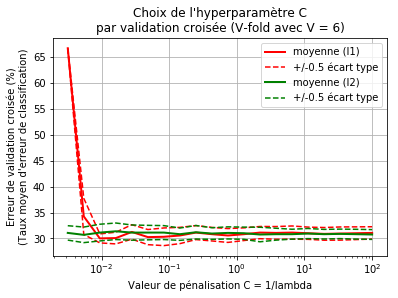

Détermination des paramètres optimaux en 12.5 s
Pénalisation l1, valeur optimale : C = 0.01
Pénalisation l2, valeur optimale : C = 0.01


In [40]:
nb_value = 20 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2.5,2,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', 
                             tol=0.01, random_state=42, 
                             class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train,
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, 
                                                     X_train, 
                                                     y_train, 
                                                     cv=cv, 
                                                     scoring='accuracy'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, 
                                                    X_train, 
                                                    y_train, 
                                                    cv=cv, 
                                                    scoring='accuracy'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:],
             'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel("Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l2)]))

In [41]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l1', 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 73.0 %
- Precision : 78.2 % (Happy # positive class)
- Recall : 78.8 %
- F1 score : 78.5 %


In [42]:
# Learning on full training set with optimals hyperparameters 
# and score evaluation on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l2)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Model score
- Accuracy : 71.5 %
- Precision : 80.4 % (Happy # positive class)
- Recall : 72.0 %
- F1 score : 75.9 %


[ 0.28918924  0.26094902  0.26035124  0.12293843  0.12056448  0.11758471
  0.11086364  0.10571498  0.0924942   0.09031865  0.08520895  0.07534933
  0.07161449  0.0712178   0.06972505  0.06504603  0.06105644  0.05013991
  0.04785051  0.04574973  0.04030477  0.03818504  0.03548995  0.03470828
  0.03459128  0.03333439  0.03064415  0.02742764  0.0272144   0.0265467
  0.02586892  0.02541776  0.02531397  0.02171971  0.02116637  0.01990121
  0.01915592  0.01895105  0.01879546  0.018207    0.0178006   0.01762086
  0.01719412  0.01668544  0.01498402  0.01450985  0.01359048  0.012893
  0.00999465  0.00838993  0.00746007  0.0073291   0.00504336  0.00388026
  0.00331852  0.00290678  0.002556    0.00247781  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.        ]
[57 43 55  8 15 28 65 25 27 48 61 39 44  2 60 59 41  3 16 53 68 17 62 20  5
 12 69 14 22 66 18  4  9 33 37 23  0 13 26 24 46 31 56 40 52 49 63 45 47 19
  7 64 34 67 4

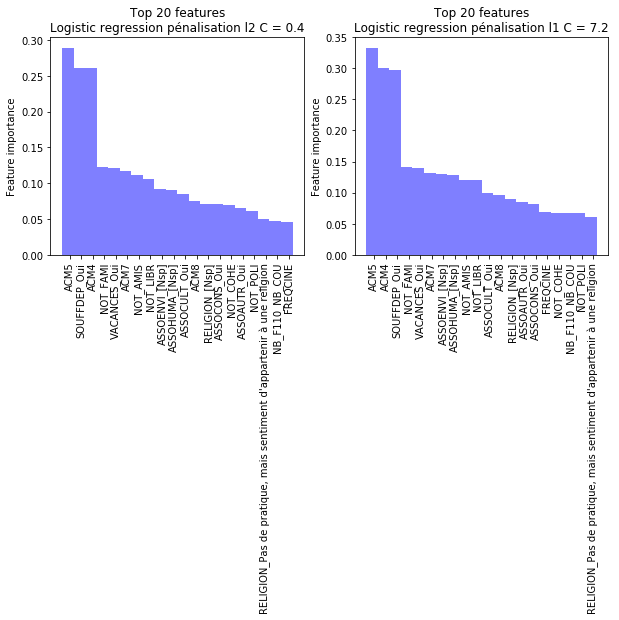

In [79]:
features = df_tmp.columns.drop(["HEUREUX_CLF"])
# Use regression coefficients to rank features
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l2)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')


clf.fit(X_train,y_train)
coef_l2 = abs(clf.coef_)
coef_sorted_l2 = -np.sort(-coef_l2).reshape(-1)
print(coef_sorted_l2)
features_sorded_l2 = np.argsort(-coef_l2).reshape(-1)
print(features_sorded_l2)
features_name = np.array(features)
features_name_sorted_l2 = features_name[features_sorded_l2]
    
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], 
                         penalty='l2', 
                         random_state=42, 
                         class_weight='balanced')
    
clf.fit(X_train,y_train)
coef_l1 = abs(clf.coef_)
coef_sorted_l1 = -np.sort(-coef_l1).reshape(-1)
features_sorded_l1 = np.argsort(-coef_l1).reshape(-1)
features_name_sorted_l1 = features_name[features_sorded_l1]

nf = min(X_train.shape[1],20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ind = np.arange(nf)    # the x locations for the groups

plt.subplot(1, 2, 1)
p1 = plt.bar(ind, coef_sorted_l2[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l2 C = 0.4' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l2[0:nf], rotation = 90)

plt.subplot(1, 2, 2)
p1 = plt.bar(ind, coef_sorted_l1[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l1 C = 7.2' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l1[0:nf], rotation = 90)

plt.show()

In [58]:
set(features_name_sorted_l1) - scope

set()

In [75]:
for i,feature in enumerate(features_name_sorted_l1):
    if i < 20:
        if feature in indiv_act_features:
            print(f"acionate {feature}, {coef_l1[abs(coef_l1) == coef_sorted_l1[i]][0]:0.4f}")

acionate NOT_FAMI, 0.1410
acionate VACANCES_Oui, 0.1394
acionate ASSOENVI_[Nsp], 0.1302
acionate ASSOHUMA_[Nsp], 0.1276
acionate NOT_AMIS, 0.1209
acionate NOT_LIBR, 0.1203
acionate ASSOCULT_Oui, 0.1001
acionate RELIGION_[Nsp], 0.0892
acionate ASSOAUTR_Oui, 0.0853
acionate ASSOCONS_Oui, 0.0816
acionate FREQCINE, 0.0681
acionate NOT_COHE, 0.0680
acionate NOT_POLI, 0.0667
acionate RELIGION_Pas de pratique, mais sentiment d'appartenir à une religion, 0.0601


In [81]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")

Determination of optimal hyperparameters in 52.0 s
Optimal values are {'max_depth': 32, 'n_estimators': 256} 
Accuracy Score of cross valdation 73.81%
Random Forest, p=70
Model score
- Accuracy : 72.0 %
- Precision : 70.9 % (Happy # positive class)
- Recall : 93.6 %
- F1 score : 80.7 %


In [82]:
# loading cdv data
file = path_data / Path("clustTest1.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

In [84]:
#score = dict()

n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

score_clustering_methods = []
clustering_methods = clustTest1.columns[0:3]

for method in clustering_methods:
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} : {len(index_scope)} elements")
        
        # treating remaining missing values        
        n_max = 2000
        df_tmp = df.loc[:,lasso_20_features | indiv_act_features | {"HEUREUX_CLF"} ].dropna()
        features = df.loc[:,lasso_20_features | indiv_act_features ].columns

        X = df_tmp.loc[:,lasso_20_features | indiv_act_features]
        y = df_tmp["HEUREUX_CLF"]

        X, y = resample(X, y)

        X = X.iloc[0:n_max,:]
        y = y.iloc[0:n_max]

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
                
        
        print(f"Number exemple: {y.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
        Score of cross valdation {100*grid.best_score_:0.2f}%")

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}
            
        cl = {'cluster' : cluster,
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res
             }
         
        score_cluster.append(cl)
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 


Analysis cluster method clust1
liste of clusters : [1 2 3 4 5 6]
cluster 1 : 295 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=70
Number of class: 2
class 0 : 35.4%
class 1 : 64.7%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
        Score of cross valdation 71.56%
cluster 2 : 1729 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=70
Number of class: 2
class 0 : 35.5%
class 1 : 64.5%
Optimal values are {'max_depth': 32, 'n_estimators': 64} 
        Score of cross valdation 74.81%
cluster 3 : 3633 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=70
Number of class: 2
class 0 : 35.4%
class 1 : 64.7%
Optimal values are {'max_depth': 32, 'n_estimators': 128} 
        Score of cross valdation 73.31%
cluster 4 : 218 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of fe

In [87]:
#print(f"F1 on full dataset : {100*score_rf['f1_macro']:0.1f}%")
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']}, f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['f1_score']
    average_score = average_score / (i+1)
    print(f"average f1 on clusters {100*average_score:0.1f}%")  

method clust1:
cluster 1, f1 macro 83.8%
cluster 2, f1 macro 79.2%
cluster 3, f1 macro 80.8%
cluster 4, f1 macro 82.7%
cluster 5, f1 macro 80.8%
cluster 6, f1 macro 82.8%
average f1 on clusters 81.7%
method clust2:
cluster 4, f1 macro 82.8%
cluster 6, f1 macro 84.8%
cluster 5, f1 macro 80.9%
cluster 1, f1 macro 82.5%
cluster 3, f1 macro 83.5%
cluster 2, f1 macro 86.9%
cluster 7, f1 macro 82.1%
average f1 on clusters 83.3%
method clust3:
cluster 5, f1 macro 82.8%
cluster 4, f1 macro 82.0%
cluster 1, f1 macro 82.6%
cluster 2, f1 macro 81.5%
cluster 3, f1 macro 81.9%
average f1 on clusters 82.2%
